# Fine-Tuning and Evaluating RoBERTa for Yelp Review Classification

## Objective

In this assignment, you will fine-tune a pre-trained RoBERTa model on the Yelp review dataset, evaluate its performance, and visualize the results.

You will learn how to preprocess data, train a model and optionally test your model and create visualizations such as a confusion matrix.

TO-DO: Please add your input where it is required.

In [1]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
#Runtime type - T4 GPU
!nvidia-smi


Wed Nov 20 18:36:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##Step 1: Load the Yelp Review Dataset
#### - Load the Yelp review dataset using the `datasets` library.
#### - Apply label mapping to convert review ratings into binary sentiment labels (negative: 1, 2, 3; positive: 4, 5).



In [3]:
import datasets
from datasets import load_dataset

dataset = load_dataset('yelp_review_full', split = 'train')

#randomly shuffle the data to take a small subset of it
dataset = dataset.shuffle(seed = 42).select(range(1000))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
dataset

Dataset({
    features: ['label', 'text'],
    num_rows: 1000
})

In [5]:


# Define the mapping function
#write your if-else statement such that it could create binary labels.
def label_mapping(example):
    example['label_binary'] = 1 if example['label'] >= 3 else 0
    return example

# Apply the mapping function
dataset = dataset.map(label_mapping, batched=False)
dataset


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'text', 'label_binary'],
    num_rows: 1000
})

In [6]:
dataset = dataset.remove_columns('label')

### Step 2: Split the Dataset

- Feel free to adjust test_size based on your preferred proportions.
- Example:
           -  80-10-10 Split (Allocate 80% of data to training, 10% to validation, and 10% to testing.)
           -  70-15-15 Split
           -  60-20-20 Split   





In [7]:
# Split the dataset
train_test_split = dataset.train_test_split(test_size= 0.2 , seed = 42) #add your input test_size(in decimal)
train_data = train_test_split['train']
test_data = train_test_split['test']

#validation split
val_test_split = test_data.train_test_split(test_size= 0.5, seed = 42 ) #add your input valid_test_size(in decimal)

train_dataset = train_test_split['train']
val_dataset = val_test_split['train']
test_dataset = val_test_split['test']



### Step 3: Load the RoBERTa Model and Tokenizer

- Load the pre-trained RoBERTa model for sequence classification.
- For Example:
                   'roberta-base'
- Add the num_labels to the model.


In [8]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels= 2)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Step 4: Tokenize the Dataset(Nothing to change here)

- Use the RoBERTa tokenizer to preprocess the text data.


In [11]:
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label_binary'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label_binary'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label_binary'])


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

### Step 5: Prepare DataLoader

- Prepare DataLoader for training and validation datasets.

- set your batch_size to '8' then you could change it to '16' or '32' depending on your Virtual RAM usage(which could be checked using !nvidia-smi command)

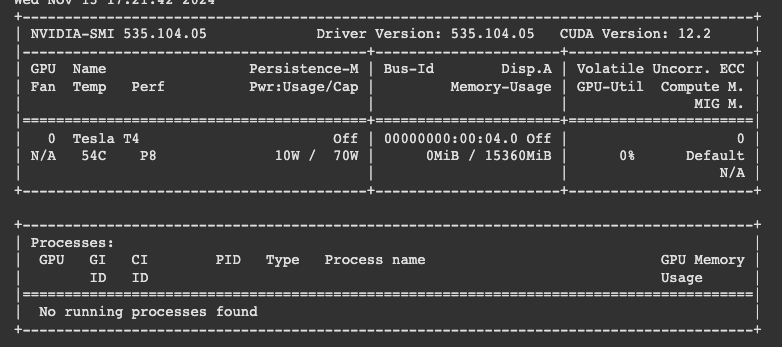

Please note in above screen-shot you are using NVIDIA Tesla T4 GPU with 15,360 MiB (or about 15 GB) of VRAM on Google Colab.

Some Tips to keep in mind when changing batch size:

- Increase to 16 or 32 if you find that there is sufficient VRAM available.
  You can monitor VRAM usage with nvidia-smi or Colab's resource monitor.

- Use gradient accumulation if you need an effective batch size larger than
  what the memory allows.
  For example, if a batch size of 16 is too large, you could use a batch size of 8 with gradient_accumulation_steps=2 to simulate a batch size of 16.

In [15]:
from torch.utils.data import DataLoader

# Define the batch size
batch_size = 8 # Suggested values: 8, 16, 32

# Create DataLoaders for train, validation, and test sets
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [16]:
train_dataset[0]

{'label_binary': tensor(0),
 'input_ids': tensor([    0,   133,   766, 13966, 14758,    16,  2345,     9,    10,  3834,
           282, 11032,    13,    42,    36, 17894,   352,    43,  5862,   470,
          2391,    14, 17859,    11, 14254,   260,     8, 43527,  7372,   689,
             4,  1437,  3216,     6,  9366,    16,    15,     5,  5765,   131,
           959,     6,    77,    38,   439,    13,  4592,     6,    38,   399,
            75,   192,   143, 26432,   281,   145,  2740,     4, 37457,   282,
         37457,   282,   100,  1240,   233,     9,   127,  1035,    11, 25687,
            94,    76,     6,     8,    38,    56,   103,  3326, 15134,  1862,
         13102,   687,   281,   159,    89,     4,  1437,  1773,   172,     6,
            38,   348,    56,    10,  1473, 13102, 13253, 32659,     6,     8,
            77,    38,   794,     5,  1203,    11,     5,  2931,     6,    38,
         11464,    38,  1017,   492,   106,    10,   738,     4,  1437,   616,
           

### Step 6: Set Up Optimizer and Scheduler

- Configure the optimizer and learning rate scheduler for fine-tuning.

Please refer to suggested values alongside for filling the blanks
        
        - set the learning rate value
        - set the number of epochs
        - learning rate scheduler
        - num_warmup_steps


In [17]:
from transformers import AdamW, get_scheduler
import torch

# Define the optimizer with a learning rate
optimizer = AdamW(model.parameters(), lr= 5e-5 )  # Suggested values: 5e-5, 3e-5, 2e-5

# Set the number of epochs for training
num_epochs = 3  # Suggested values: 3, 5, 10

# Calculate the total number of training steps
num_training_steps = num_epochs * len(train_dataloader)

# Define a learning rate scheduler
lr_scheduler = get_scheduler(
    name= 'linear',  # Suggested value: 'linear' (others: 'cosine', 'constant')
    optimizer=optimizer,
    num_warmup_steps= 0,  # Suggested values: 0, 100, 500 (tuning this may help with stability)
    num_training_steps=num_training_steps
)

# Set up the device (GPU if available, otherwise CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

### Step 7: Fine-Tune the Model

- Train the RoBERTa model on the Yelp review dataset and track the training and validation loss and accuracy.

Please fill in the blanks with the suggested values:

  
    - torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm= BLANK)
      Purpose: Sets the gradient clipping threshold to prevent exploding gradients.

In [19]:
from tqdm.auto import tqdm

# Tracking progress with a progress bar
progress_bar = tqdm(range(num_training_steps))

# Set the model to training mode
model.train()

# Lists to store metrics for each epoch
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")


    # Training metrics for the epoch
    epoch_train_loss = 0
    epoch_train_correct = 0
    epoch_train_total = 0

    # Training loop
    for batch in train_dataloader:
        # Move batch data to the appropriate device
        batch = {k: v.to(device) for k, v in batch.items()}
        print(batch)


        # Forward pass
        batch['labels'] = batch.pop('label_binary')
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        # Track training loss
        epoch_train_loss += loss.item()

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=-1)
        epoch_train_correct += (predictions == batch['labels']).sum().item()
        epoch_train_total += batch['labels'].size(0)

        # Backward pass
        loss.backward()

        # Apply gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Suggested values: 1.0, 0.5

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()  # Reset gradients

        # Update the progress bar
        progress_bar.update(1)

    # Calculate and log average training loss and accuracy for the epoch
    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_accuracy = epoch_train_correct / epoch_train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/3
{'label_binary': tensor([0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0'), 'input_ids': tensor([[    0, 32537,   116,  ...,     1,     1,     1],
        [    0, 21169, 18331,  ...,     1,     1,     1],
        [    0, 21077,  6355,  ...,     1,     1,     1],
        ...,
        [    0,   170,    58,  ...,     1,     1,     1],
        [    0,   100,  1276,  ...,  1661,   932,     2],
        [    0, 39539, 16963,  ...,     1,     1,     1]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}
{'label_binary': tensor([0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0'), 'input_ids': tensor([[    0, 29233,  8224,  ...,     1,     1,     1],
        [    0, 19065,  5466,  ...,     1,     1,     1],
        [    0, 19065,    13,  ...,     1,     1,     1],
        ...,
       

In [20]:
#saving trained model[OPTIONAL STEP]

out_dir = "/content/sample_data/out_dir" #write the name of your output directory
model.save_pretrained(out_dir)
tokenizer.save_pretrained(out_dir)

print("Model and tokenizer saved to:", out_dir)

Model and tokenizer saved to: /content/sample_data/out_dir


### Step 8: Evaluate the Model (Nothing to change here)

- Evaluate the model on the validation set and plot confusion matrix.


In [22]:
# Lists to store validation metrics for each epoch
val_losses = []
val_accuracies = []

# Validation metrics for the epoch
model.eval()
epoch_val_loss = 0
epoch_val_correct = 0
epoch_val_total = 0

# Validation loop (no gradient calculation)
with torch.no_grad():
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        batch['labels'] = batch.pop('label_binary')
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        # Track validation loss
        epoch_val_loss += loss.item()

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=-1)
        epoch_val_correct += (predictions == batch['labels']).sum().item()
        epoch_val_total += batch['labels'].size(0)

# Calculate and log average validation loss and accuracy for the epoch
avg_val_loss = epoch_val_loss / len(val_dataloader)
val_accuracy = epoch_val_correct / epoch_val_total
val_losses.append(avg_val_loss)
val_accuracies.append(val_accuracy)

print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Validation Loss: 0.6260, Validation Accuracy: 0.8900


## Model Testing Function (OPTIONAL)
**Note: Nothing to change here

**The test_model function evaluates the model on the test data, calculating test loss, accuracy, and providing a classification report and confusion matrix for detailed performance insights.**

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def test_model(model, dataloader, device):
    model.eval()  # evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_predictions = []

    # No gradient calculation for testing
    with torch.no_grad():
        for batch in dataloader:
            # Move batch data to the appropriate device
            batch = {k: v.to(device) for k, v in batch.items()}
            batch['labels'] = batch.pop('label_binary')

            # Forward pass
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            # Track test loss
            total_loss += loss.item()

            # Calculate accuracy
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == batch['labels']).sum().item()
            total_predictions += batch['labels'].size(0)

            # Collect labels and predictions for confusion matrix
            all_labels.extend(batch['labels'].cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calculate average test loss and accuracy
    avg_test_loss = total_loss / len(dataloader)
    test_accuracy = correct_predictions / total_predictions

    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Print a classification report
    print("\nClassification Report:\n", classification_report(all_labels, all_predictions, target_names=["Negative", "Positive"]))

    # Plot confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.show()


### Final Step: Model testing on test_dataloader (OPTIONAL)

You have already trained the model.Now test the model using the test_dataloader

Test Loss: 0.3809
Test Accuracy: 0.9100

Classification Report:
               precision    recall  f1-score   support

    Negative       0.95      0.90      0.93        62
    Positive       0.85      0.92      0.89        38

    accuracy                           0.91       100
   macro avg       0.90      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100



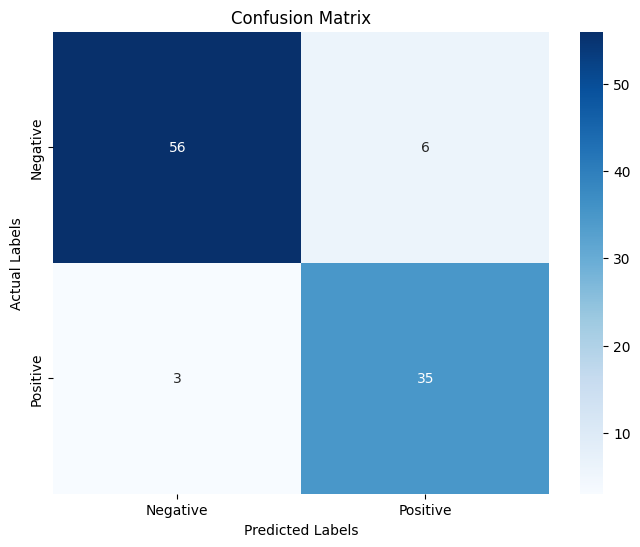

In [26]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model(model, test_dataloader, device)


Please write your insights about the model performance here.


**Answer:**

The model gives high accuracy in test data of 91% and low loss of 39%. So we can conclude that model performs well with no overfitting or underfitting.

Moreover, FP and FN (3 and 6 respsctively) also low when compared to TP and TN. So model performs well.




